# Extreme Heat Hazard
This notebook calculates the urban risk index for Extreme heat (EXH)
hazard.  The URI calculation has three components: expected loss, social vulnerability, and resilience capacity.  

## 1. Expected Loss
Import expected losses and plot each one.  

Importing EXH expected annual losses.....
 
.....Factor:  Mortality
.....Receptor:  People
.....Category:  Mortality
 
.....Factor:  Morbidity
.....Receptor:  People
.....Category:  Morbidity
 
.....Factor:  Power Loss
.....Receptor:  People
.....Category:  Indirect Cost
 
Import complete.
 


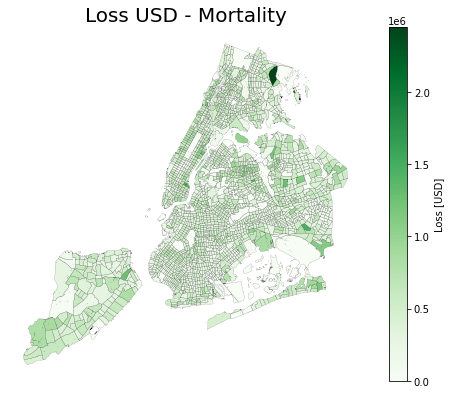

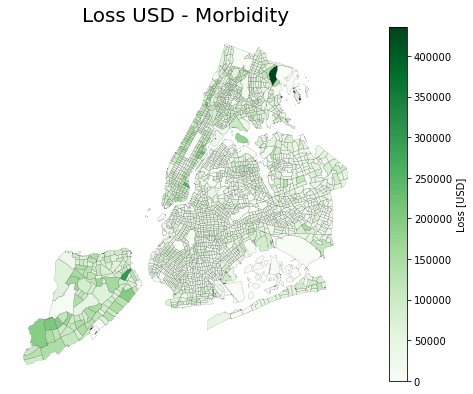

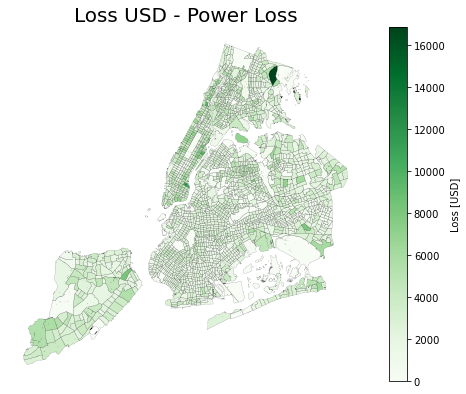

In [1]:
import URI.MISC.params_1 as params
import URI.MISC.utils_1 as utils
import URI.MISC.plotting_1 as plotting
from CLASSES import class_EL_SV_CR_1 as URI
import matplotlib.pyplot as plt
import geopandas as gpd
import os
utils.set_home()

df_consequences = params.CONSEQUENCES
hazard_name = "EXH"

#get list of consequences
df_cons = params.CONSEQUENCES.copy()
#get columns for this hazard
haz_columns = [col for col in df_cons.columns if hazard_name in col]
df_cons = df_cons[haz_columns]
df_cons.index = range(len(df_cons))
df_cons.dropna(inplace=True)

print("Importing {} expected annual losses.....".format(hazard_name))
print(" ")
ESL = URI.ESL(hazard_name = hazard_name)
for idx in df_cons.index:
    this_factor = df_cons.at[idx, '{}_Factor'.format(hazard_name)]
    this_receptor = df_cons.at[idx, '{}_Receptor'.format(hazard_name)]
    this_subcomponent = df_cons.at[idx, '{}_Subcomponent'.format(hazard_name)]
    this_path = df_cons.at[idx, '{}_Path_Name'.format(hazard_name)]
    this_abbrv = df_cons.at[idx, '{}_Abbrv'.format(hazard_name)]
    print(".....Factor:  {}".format(this_factor))
    print(".....Receptor:  {}".format(this_receptor))
    print(".....Category:  {}".format(this_subcomponent))
    print(" ")
    #add consequence
    path_consequence =   params.PATHNAMES.at[this_path, 'Value']
    gdf_consequence = gpd.read_file(path_consequence)
    col_name = 'ESL_' + this_abbrv
    ESL.add_consequence(this_factor.replace(" ", "_"), this_receptor.replace(" ", "_"), gdf_consequence)
    #plot
    plotting.plot_ESL_nb(hazard_name, ESL.consequence[this_factor.replace(" ", "_")]["map_tract"], 'Loss USD - {}'.format(this_factor))
print("Import complete.".format(hazard_name))
print(" ")


#### 1b. Expected Loss Total
The total expected losses are the sum of losses from each individual consequence.  

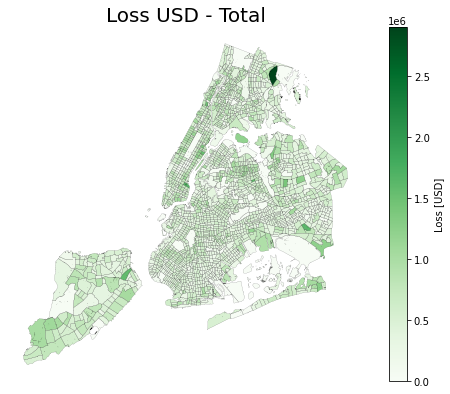

In [2]:
#save result
path_save = params.PATHNAMES.at['OUTPUTS_folder', 'Value'] + r'\ESL\ESL_{}_tract.shp'.format(hazard_name, hazard_name)
ESL.ESL_map.to_file(path_save)

#plot
plotting.plot_ESL_nb(hazard_name, ESL.ESL_map, 'Loss USD - Total')


## 2. Social Vulnerability Score
The Social Vulnerability is based on the CDC social vulnerability index.  

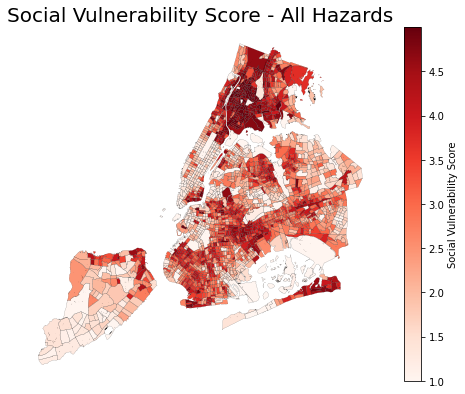

In [3]:
path_SOV = params.PATHNAMES.at['OUTPUTS_folder', 'Value'] + r'\\SOV\SOV_tract.shp'
gdf_SOV = gpd.read_file(path_SOV)
SOV = URI.SOV(hazard_name = hazard_name, map_tract = gdf_SOV)


#plot
plotting.plot_SOV_nb(SOV.SOV_map)

## 3. Resilience Capacity Score
The Resilience Capacity is the sum of four scores:
- Community Capital
- Mitigation Landscape
- Response Capacity
- Recovery Resources


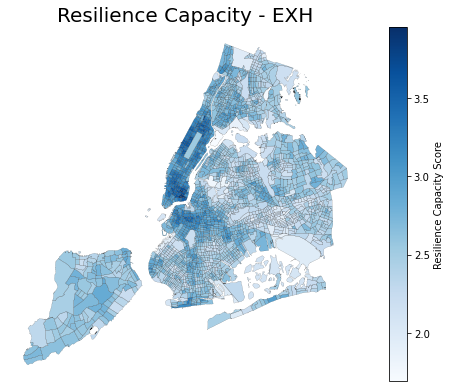

In [4]:
path_RCA = params.PATHNAMES.at['OUTPUTS_folder', 'Value'] + r'\\RCA\RCA_{}_tract.shp'.format(hazard_name)
gdf_RCA = gpd.read_file(path_RCA)
RCA = URI.RCA(hazard_name=hazard_name, map_tract=gdf_RCA)

#
plotting.plot_RCA_nb('EXH', RCA.RCA_map)

## 4. Calculate URI Score
The URI equation is URI = ESL * SOV / RCA.  The result is clustered into a score of 1 (low) to 5 (high).

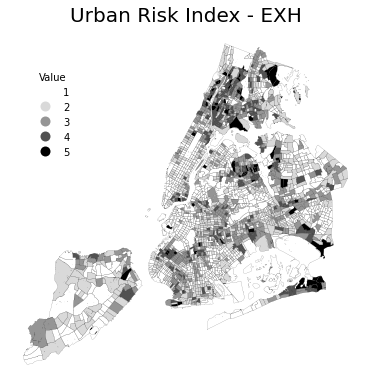

In [5]:
URI_HAZ = URI.URI(hazard_name=hazard_name, ESL=ESL, SOV=SOV, RCA=RCA)
URI_HAZ.calc_URI()

#save result
path_save = params.PATHNAMES.at['OUTPUTS_folder', 'Value'] + r'\URI\URI_{}_tract.shp'.format(hazard_name, hazard_name)
URI_HAZ.URI_map.to_file(path_save)
URI_HAZ.save_URI_FULL()
plotting.plot_URI_nb(hazard_name, URI_HAZ.URI_map)